## Data Ingestion

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rc("figure", figsize=(15, 6))

In [3]:
stock_data = pd.read_csv("../Data/FACT-stockprice-history.csv")

In [4]:
stock_data.head()

,Date,Close,High,Low,Open,Volume
0,2002-07-01,45.318386,46.564766,44.371136,44.969397,51968
1,2002-07-02,46.465050,47.561867,45.767080,46.265632,62553
2,2002-07-03,46.365341,47.362445,46.016356,46.415196,19050
3,2002-07-04,46.116066,47.262737,45.368238,47.163025,28525
4,2002-07-05,45.717224,46.664474,45.368239,46.664474,19528


In [5]:
stock_data.tail()

,Date,Close,High,Low,Open,Volume
5620,2025-02-17,748.799988,762.950012,716.950012,730.000000,443470
5621,2025-02-18,709.049988,754.700012,701.000000,754.700012,430306
5622,2025-02-19,726.700012,740.250000,695.250000,708.000000,377628
5623,2025-02-20,716.400024,722.500000,688.000000,704.900024,952597
5624,2025-02-21,706.400024,739.299988,701.700012,715.750000,390935


There is data from year 2002 to 2025. The dataset appear to be sorted by date.

In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5625 entries, 0 to 5624
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5625 non-null   object 
 1   Close   5625 non-null   float64
 2   High    5625 non-null   float64
 3   Low     5625 non-null   float64
 4   Open    5625 non-null   float64
 5   Volume  5625 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 263.8+ KB


In [7]:
# Date is of object type, converting it into datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')
print(stock_data["Date"].dtype)

datetime64[ns]


## EDA

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [9]:
stock_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,5625,2013-10-05 01:11:25.439999744,2002-07-01 00:00:00,2008-01-14 00:00:00,2013-09-27 00:00:00,2019-06-20 00:00:00,2025-02-21 00:00:00,NaN
Close,5625.0,100.545428,14.507866,25.824997,33.702118,48.80825,1133.322021,201.72553
High,5625.0,103.578039,16.053378,26.722391,34.998352,50.254052,1185.819822,207.37617
Low,5625.0,98.386235,13.959458,25.127025,33.004146,47.910852,1077.677397,197.582099
Open,5625.0,100.882404,16.053378,25.924709,34.051107,49.107379,1132.223137,202.031969
Volume,5625.0,319047.503644,0.0,20200.0,55068.0,194855.0,36991384.0,1205603.978151


All of Open, High, Low and Close has prices concentrated on the lower end indicated by the 3 quartiles having similar prices under 50, while the maximum price shoots upwards to above 1000.

In [10]:
stock_data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

No null values in dataset

In [11]:
# Checking for duplicates
print(stock_data.duplicated().sum())

0


In [12]:
# setting date as the index
stock_data.set_index('Date', inplace=True)

In [13]:
stock_data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2002-07-01,45.318386,46.564766,44.371136,44.969397,51968
2002-07-02,46.465050,47.561867,45.767080,46.265632,62553
2002-07-03,46.365341,47.362445,46.016356,46.415196,19050
2002-07-04,46.116066,47.262737,45.368238,47.163025,28525
2002-07-05,45.717224,46.664474,45.368239,46.664474,19528


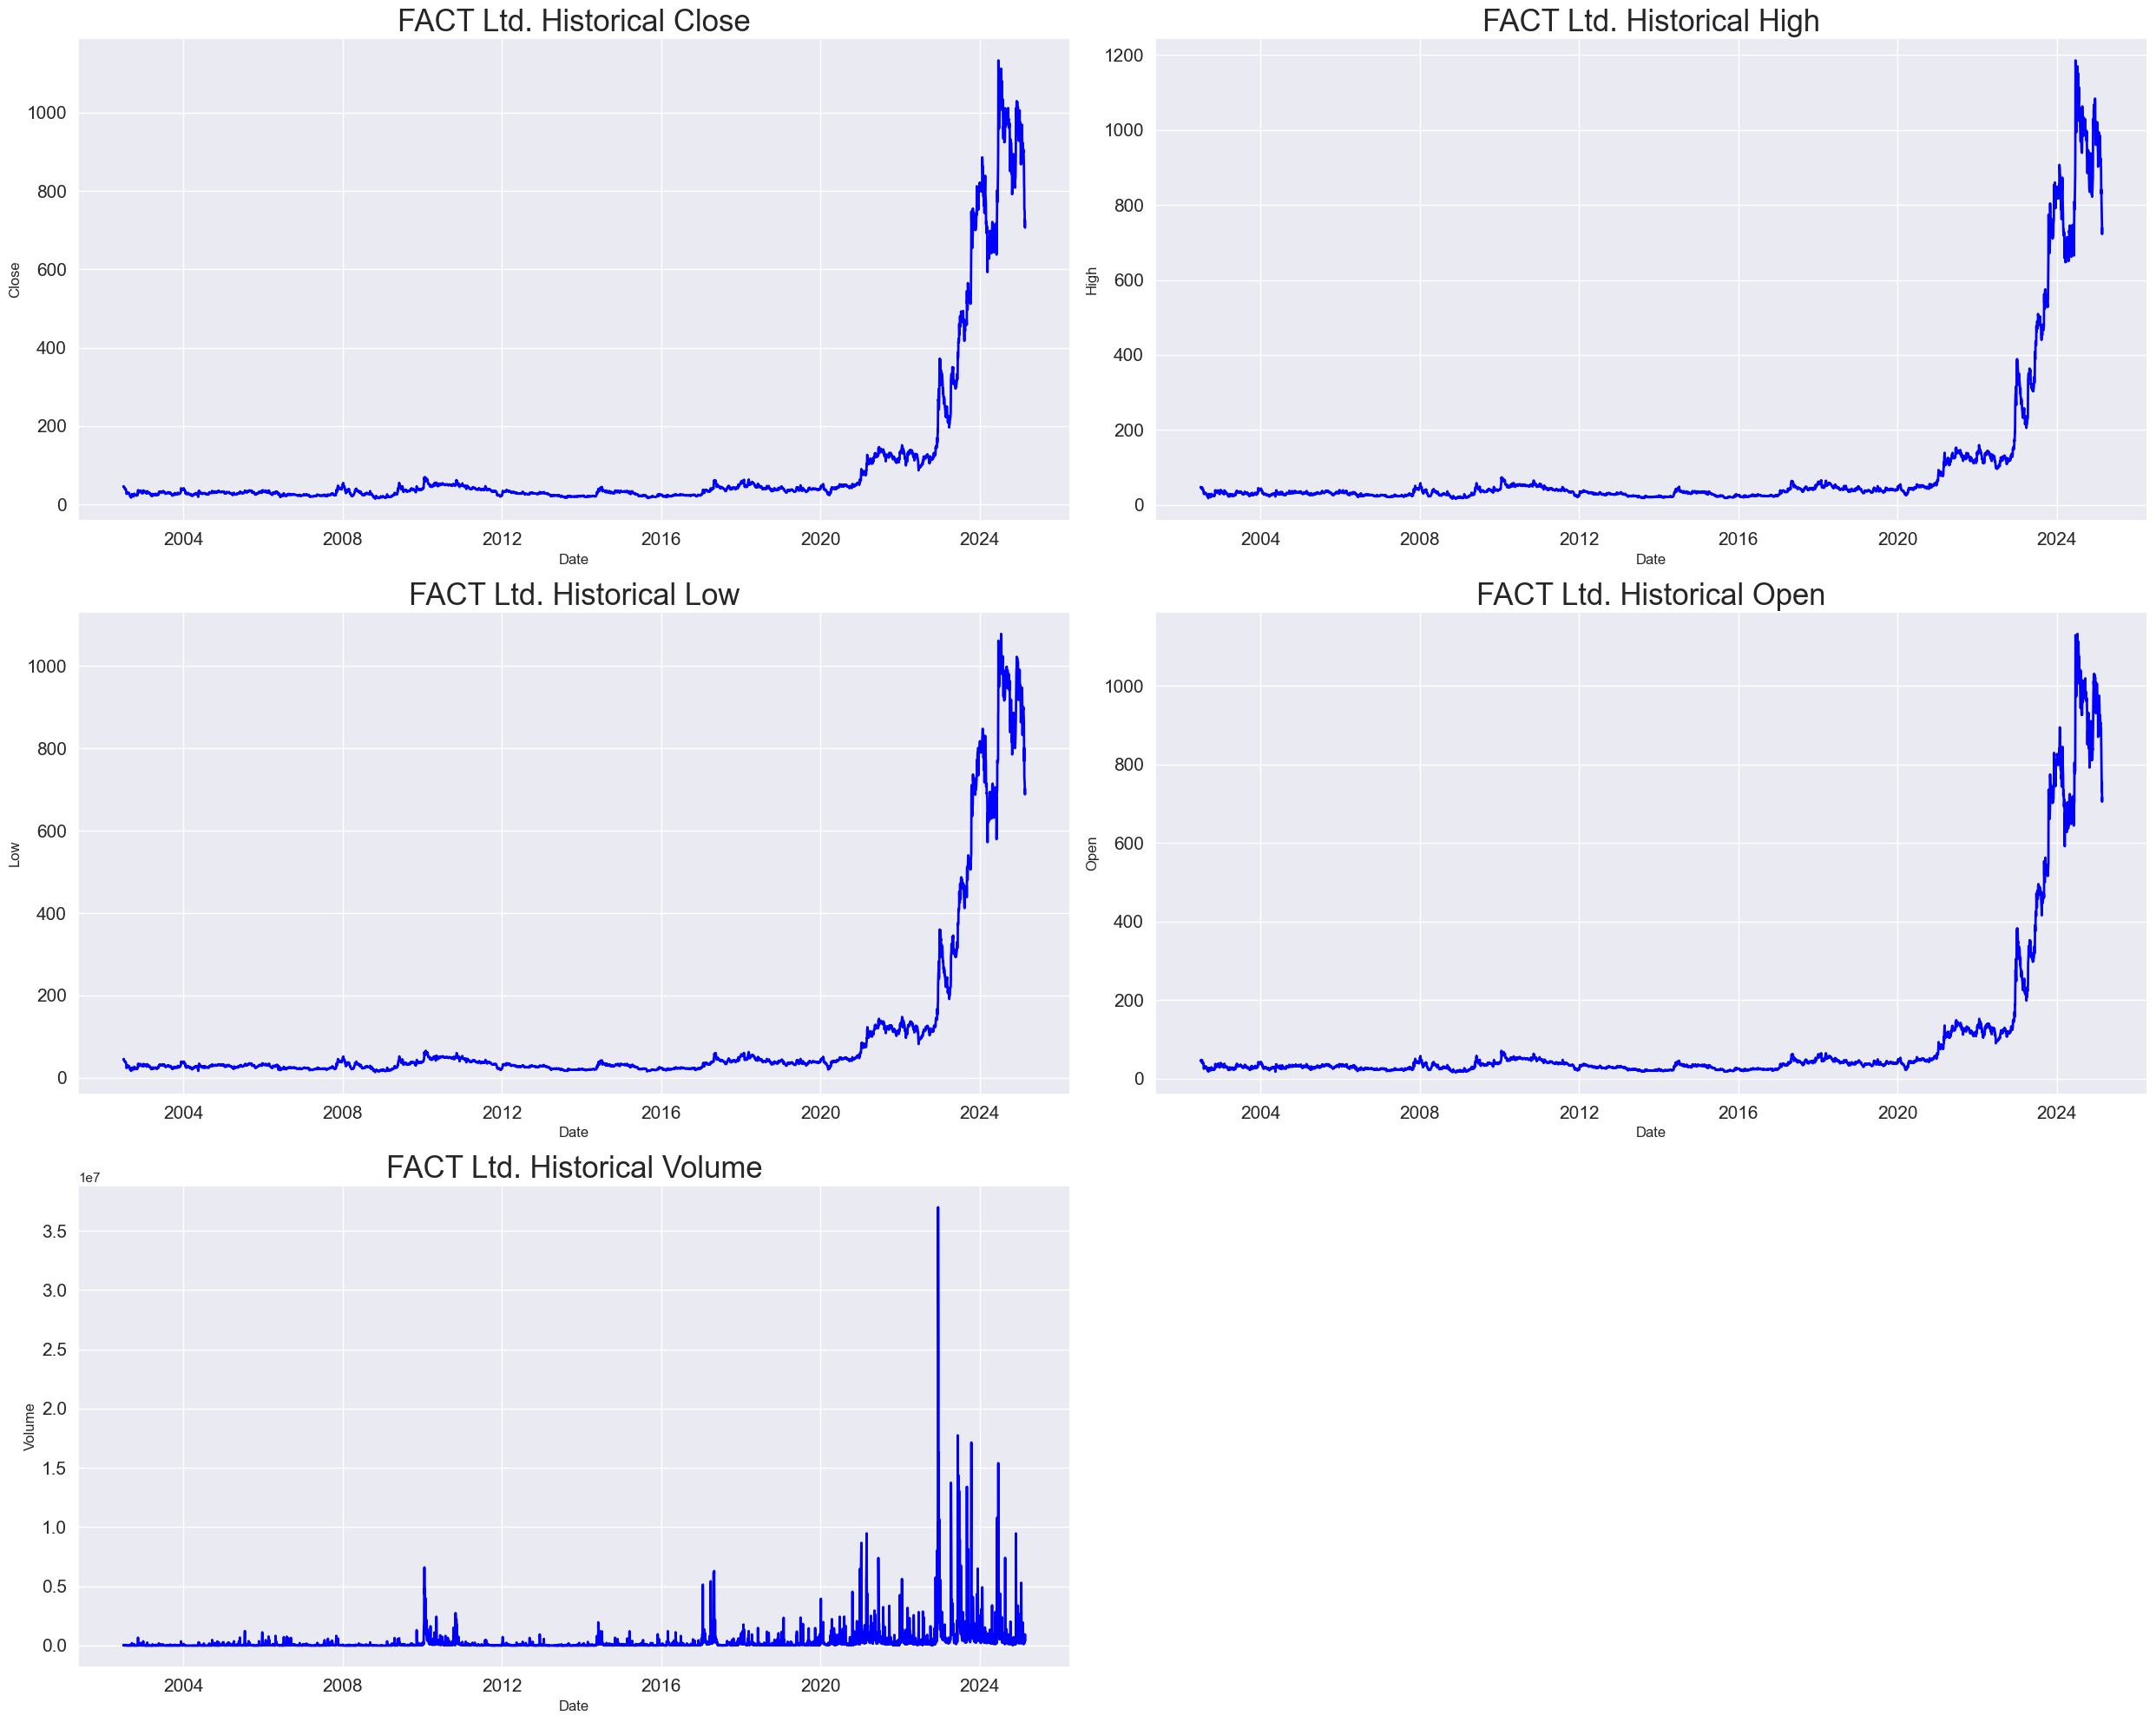

In [14]:
plt.figure(figsize=(25,20))
sns.set_theme(style='darkgrid')
for i,col in enumerate(stock_data.columns):
    plt.subplot(3,2,i+1)
    sns.lineplot(stock_data[col], color='blue', linewidth=2)
    plt.title(f"FACT Ltd. Historical {col}", fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.tight_layout()

The prices are relatively stagnant over the years with occassional jumps, but the real breakout seem to have begun after 2020.  
There is a definite uptrend for the stock price which is evident from the plot.  

The plots for Open, Close, High and Low seems to be identical except for very minor differences. As is the case with the stock market these prices do not deviate very far from each other on any usual day.

The volume data indicates strong trading interest in the stock during the recent years. There is a steady rise after 2020. Volume could be an important feature in forecasting the future prices.

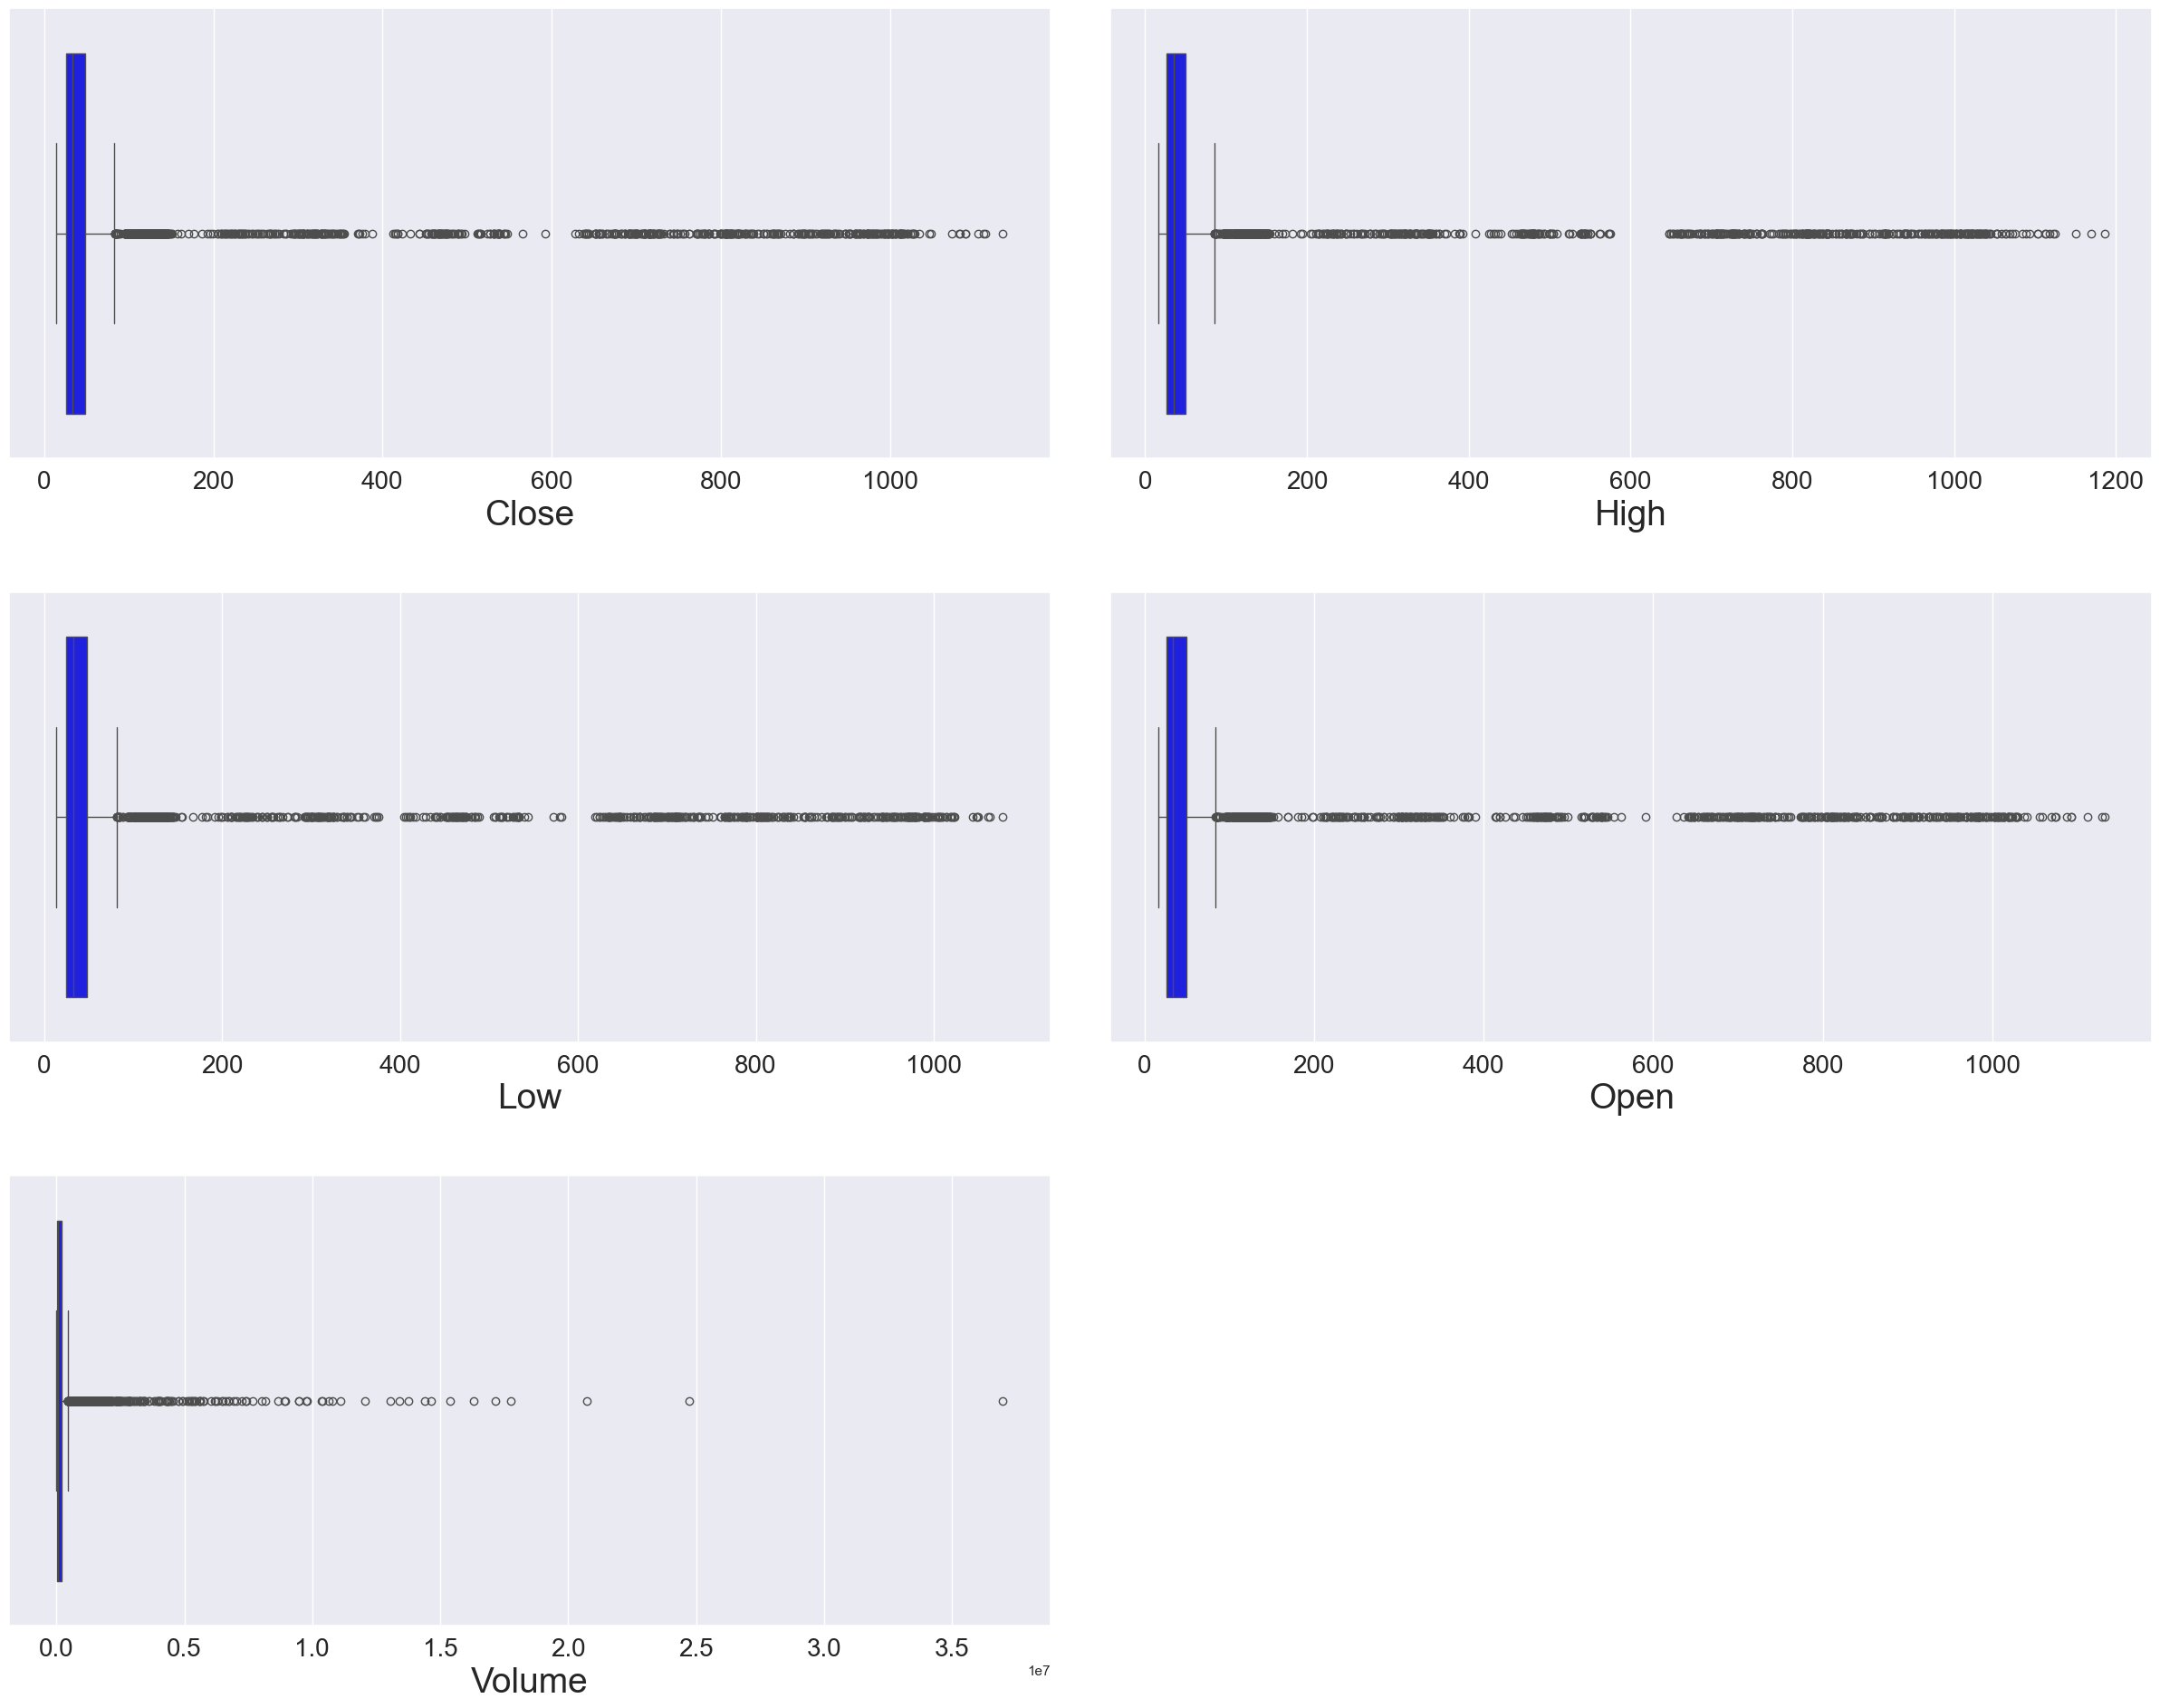

In [15]:
plt.figure(figsize=(25,20))
sns.set_theme(style="darkgrid")
for i,col in enumerate(stock_data.columns):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=stock_data[col], color='blue')
    plt.xlabel(col, fontsize=28)
    plt.xticks(fontsize=20)
plt.tight_layout(pad=4)

All the features have very extreme outliers in boxplots, but these outliers are not random noise but significant value increase over time.  
The extreme values in the Volume feature is verifying of the observation that a very high trading activity has been happening in recent times.

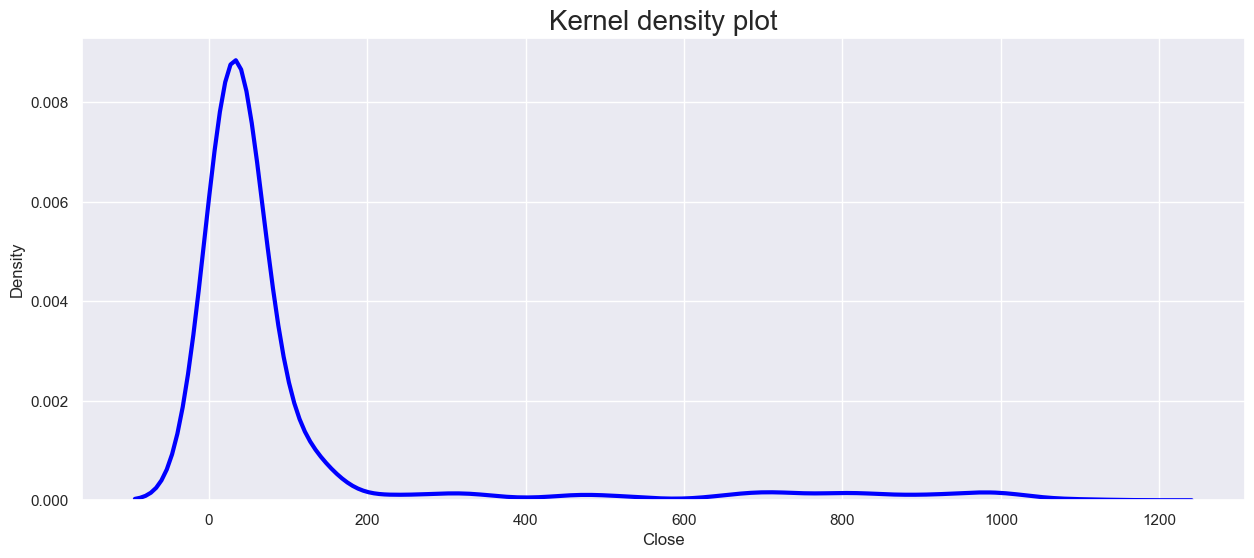

In [16]:
sns.kdeplot(stock_data["Close"], linewidth=3, color="blue")
plt.title("Kernel density plot", fontsize=20)
plt.show()

As seen from the plot of closing price itself, much of the data is concentrated in the lower price point of the data during is long period of relative stagnation, which is also verified by the KDE plot.

25 day Rolling mean and rolling standard-deviation of Closing price

In [17]:
def check_stationarity(feature:pd.Series):

    #rolling statistics
    rolmean = feature.rolling(50).mean()
    rolstd = feature.rolling(50).std()

    sns.lineplot(feature, color='blue', label=feature.name, linewidth=2)
    sns.lineplot(rolstd, color='orange', label='50 day rolling Std', linewidth=3)
    sns.lineplot(rolmean, color='red', linestyle='dashed', label='50 day rolling mean', linewidth=3)
    plt.legend(loc='best', fontsize = 15, shadow=True)
    plt.title(f"{feature.name} - Rolling mean & Standard Deviation", fontsize=20)
    plt.show()

    print("Results of adf test")
    print("="*50)
    adft = adfuller(feature, autolag='AIC')
    # output for adf test returns plain values
    # making the return values structured, with the proper headers

    output = pd.Series(adft[0:4],index=['adf test statistic','p-value','No. of lags used','Number of observations used'])
    for key,value in adft[4].items():
        output[f'critical value {key}'] =  value
    print(output)

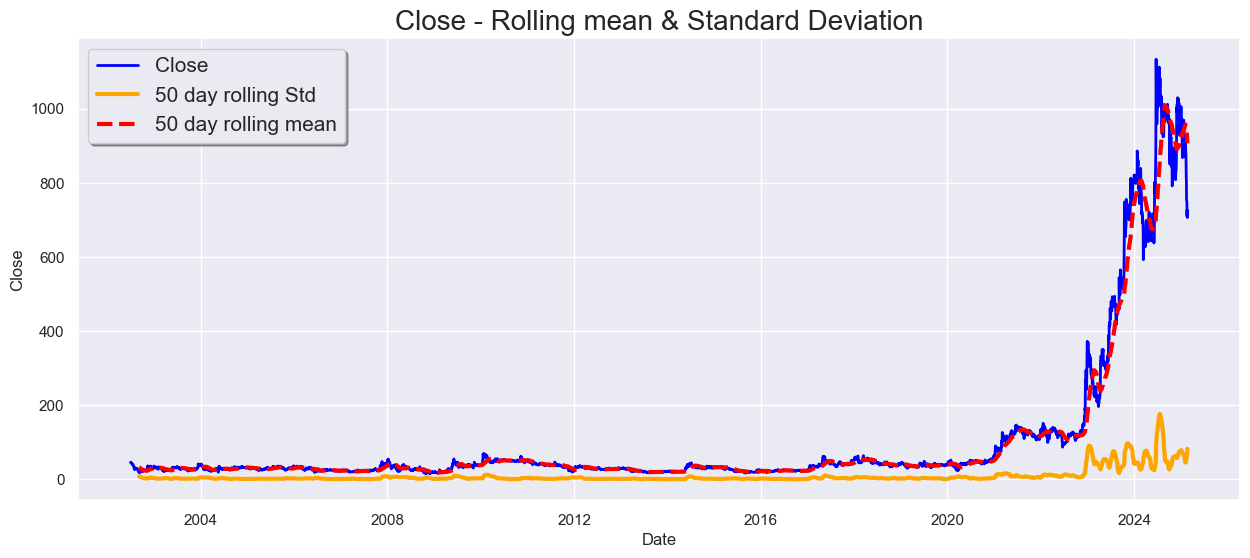

Results of adf test
adf test statistic                0.672789
p-value                           0.989279
No. of lags used                 33.000000
Number of observations used    5591.000000
critical value 1%                -3.431520
critical value 5%                -2.862057
critical value 10%               -2.567045
dtype: float64


In [18]:
# stationarity for Close price
check_stationarity(stock_data["Close"])

The graph of the data clearly puts the non-stationarity of the data and the Augmented Dickey Fuller test confirms that observation.  
The p-value returned is greater than 0.05 and the test statistic is greater than the critical value.  

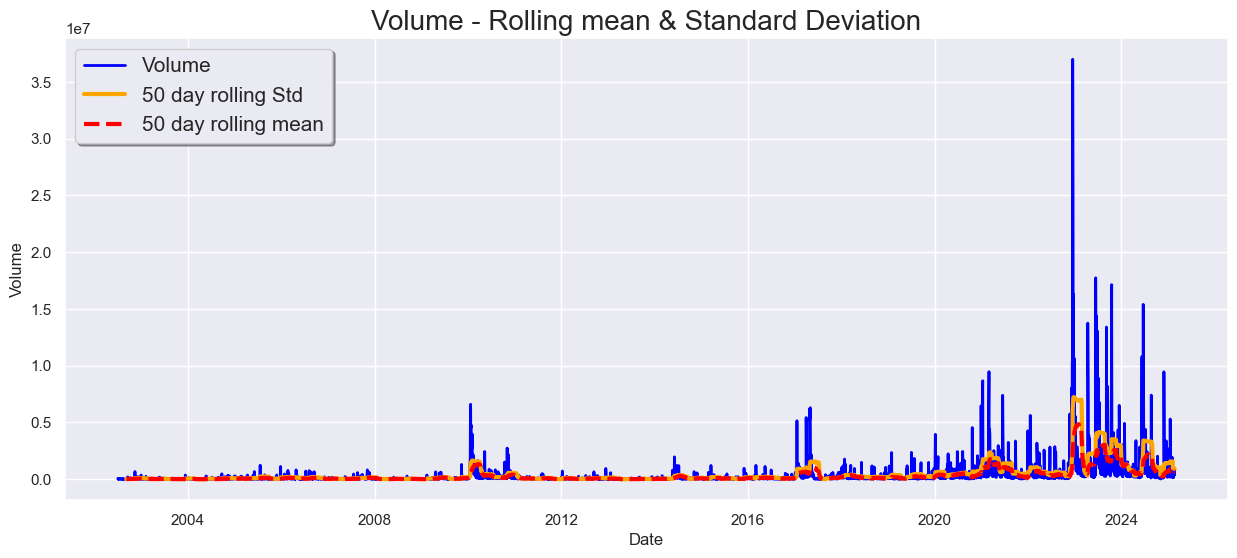

Results of adf test
adf test statistic            -1.009626e+01
p-value                        1.088872e-17
No. of lags used               2.400000e+01
Number of observations used    5.600000e+03
critical value 1%             -3.431518e+00
critical value 5%             -2.862056e+00
critical value 10%            -2.567045e+00
dtype: float64


In [19]:
# Stationarity for Volume feature
check_stationarity(stock_data['Volume'])

Similarly, the Volume feature is also non-stationary.  
p-value > 0.05  
ADF test statistic > critical value